# 字符级的人名分类，来源于官网教程

https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

In [1]:
from io import open
import glob
import string
import unicodedata
import random
import time
import os
import math
import torch
import torch.nn as nn

# 获取常用字符和标点


In [2]:
# 获取常用字符和标点
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
print('n_letters:',n_letters)

n_letters: 57


# unicode转ascii函数

In [3]:
# 暂时不考虑编码，这个函数作用是去掉一些语言中的重音标记
def unicodeToAscii(s):
    return ''.join(
       c for c in unicodedata.normalize('NFD',s)
        if unicodedata.category(c) != 'MN' and c in all_letters
    )

In [4]:
print(unicodeToAscii('Ślusàrski'))

Slusarski


# 构建类别字典，每个类别对应一个list的人名数据

In [5]:
category_lines = {}
all_categories = []

def findFiles(path):
    return glob.glob(path)

def readLines(filename):
    lines = open(filename,encoding='utf=8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('../data/data_name/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print('国家列表')
all_categories

国家列表


['Arabic',
 'Chinese',
 'Czech',
 'Dutch',
 'English',
 'French',
 'German',
 'Greek',
 'Irish',
 'Italian',
 'Japanese',
 'Korean',
 'Polish',
 'Portuguese',
 'Russian',
 'Scottish',
 'Spanish',
 'Vietnamese']

In [6]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


# 名字转为tensors

In [7]:
def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1,n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# 每个letter对应一个2d矩阵，多余的一维由于pytorch假设输入都是按批次的，因此此处假设batch为1
def lineToTensor(line):
    tensor = torch.zeros(len(line),1,n_letters)
    for li,letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor 

In [8]:
print(letterToTensor('J'))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])


In [9]:
print(lineToTensor('Jones').size())

torch.Size([5, 1, 57])


# 构建网络

![img](./Classifying_names_1.png)

In [10]:
class RNN(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size+hidden_size,hidden_size)
        self.i2o = nn.Linear(input_size+hidden_size,output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self,input,hidden):
        combined = torch.cat((input,hidden),1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output,hidden
    
    def initHidden(self):
        return torch.zeros(1,self.hidden_size)

# 测试网络

In [11]:
n_hidden = 128
rnn = RNN(n_letters,n_hidden,n_categories)

In [12]:
rnn

RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [13]:
input = letterToTensor('A')
hidden = torch.zeros(1,n_hidden)

output, next_hidden = rnn(input,hidden)
print("input_size:\n" + str(input.size()))
print(output)
print(next_hidden)

input_size:
torch.Size([1, 57])
tensor([[-2.7980, -2.8928, -2.8509, -2.9251, -2.8263, -2.9838, -2.9996, -2.9020,
         -2.7853, -2.8744, -2.8476, -2.7923, -2.9333, -2.9512, -2.9226, -2.9269,
         -2.8984, -2.9515]], grad_fn=<LogSoftmaxBackward>)
tensor([[ 0.0070,  0.0837,  0.0311,  0.0337,  0.0106, -0.0094, -0.0104,  0.0250,
          0.0861, -0.0604, -0.0809,  0.0120,  0.0261,  0.0199,  0.0569,  0.0327,
         -0.0698, -0.0098, -0.0027, -0.0136,  0.0554,  0.0460,  0.0917, -0.1133,
          0.1091,  0.0659, -0.0575,  0.0656,  0.0486,  0.0700, -0.0733,  0.0046,
         -0.0310,  0.0906, -0.0028,  0.0139, -0.0463,  0.0619, -0.0271,  0.0151,
          0.1104,  0.0601,  0.0486, -0.0559,  0.0250,  0.0029, -0.0011, -0.0599,
          0.0445, -0.0517,  0.1120, -0.0900, -0.0659, -0.1203, -0.0585, -0.0043,
          0.0599,  0.0129,  0.0557,  0.0176, -0.0873, -0.0063, -0.0685, -0.0038,
          0.0486, -0.0662, -0.1029, -0.0654, -0.1009, -0.0284, -0.1249,  0.0672,
          0.0434, 

In [14]:
input = lineToTensor('ALbert')
hidden = torch.zeros(1,n_hidden)

output,next_hidden = rnn(input[0],hidden)

print(input.size())
print(output)
print(next_hidden)

torch.Size([6, 1, 57])
tensor([[-2.7980, -2.8928, -2.8509, -2.9251, -2.8263, -2.9838, -2.9996, -2.9020,
         -2.7853, -2.8744, -2.8476, -2.7923, -2.9333, -2.9512, -2.9226, -2.9269,
         -2.8984, -2.9515]], grad_fn=<LogSoftmaxBackward>)
tensor([[ 0.0070,  0.0837,  0.0311,  0.0337,  0.0106, -0.0094, -0.0104,  0.0250,
          0.0861, -0.0604, -0.0809,  0.0120,  0.0261,  0.0199,  0.0569,  0.0327,
         -0.0698, -0.0098, -0.0027, -0.0136,  0.0554,  0.0460,  0.0917, -0.1133,
          0.1091,  0.0659, -0.0575,  0.0656,  0.0486,  0.0700, -0.0733,  0.0046,
         -0.0310,  0.0906, -0.0028,  0.0139, -0.0463,  0.0619, -0.0271,  0.0151,
          0.1104,  0.0601,  0.0486, -0.0559,  0.0250,  0.0029, -0.0011, -0.0599,
          0.0445, -0.0517,  0.1120, -0.0900, -0.0659, -0.1203, -0.0585, -0.0043,
          0.0599,  0.0129,  0.0557,  0.0176, -0.0873, -0.0063, -0.0685, -0.0038,
          0.0486, -0.0662, -0.1029, -0.0654, -0.1009, -0.0284, -0.1249,  0.0672,
          0.0434,  0.0311, 

# 获取训练数据

In [15]:
# 展示类别
def categoryFromOutput(output):
    top_n,top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i],category_i

print(categoryFromOutput(output))

('Irish', 8)


In [16]:
# 获取训练样例
import random
def randomChoice(l):
    return l[random.randint(0,len(l)-1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)],dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category,line,category_tensor,line_tensor

for i in range(10):
    category,line,category_tensor,line_tensor = randomTrainingExample()
    print('category = ',category,'/line = ',line)

category =  Russian /line =  Hachirov
category =  Irish /line =  O'Reilly
category =  Italian /line =  Adessi
category =  Korean /line =  Bang
category =  Irish /line =  Clark
category =  Japanese /line =  Nakatoni
category =  Russian /line =  Zhavrid
category =  German /line =  Kunze
category =  Polish /line =  Wojewodka
category =  German /line =  Neumann


# 训练网络

In [17]:
criterion = nn.NLLLoss()
learning_rate = 0.005 # 过高会梯度爆炸，过低会梯度消失

def train(category_tensor,line_tensor):
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    for i in range(line_tensor.size()[0]):
        output,hidden = rnn(line_tensor[i],hidden)
        
    loss = criterion(output,category_tensor)
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(p.grad.data,alpha=-learning_rate)
    return output,loss.item()

In [18]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1,n_iters+1):
    category,line,category_tensor,line_tensor = randomTrainingExample()
    output,loss = train(category_tensor,line_tensor)
    current_loss += loss
    
    if iter % print_every == 0:
        guess,guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))
        
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 15s) 2.8749 Naylor / French ✗ (English)
10000 10% (0m 29s) 2.3844 Koma / Japanese ✗ (Czech)
15000 15% (0m 41s) 2.3849 Watt / German ✗ (Scottish)
20000 20% (0m 55s) 1.3955 Fencl / Czech ✓
25000 25% (1m 7s) 1.6823 Sartre / Portuguese ✗ (French)
30000 30% (1m 19s) 1.0220 So / Korean ✓
35000 35% (1m 31s) 0.0086 Kotsiopoulos / Greek ✓
40000 40% (1m 42s) 3.1147 Johnston / English ✗ (Scottish)
45000 45% (1m 54s) 0.4900 Stevenson / Scottish ✓
50000 50% (2m 5s) 1.4809 Janosik / Arabic ✗ (Czech)
55000 55% (2m 16s) 2.7740 Bastl / Scottish ✗ (Czech)
60000 60% (2m 28s) 1.4970 Torres / Portuguese ✗ (Spanish)
65000 65% (2m 40s) 1.4933 Habicht / German ✓
70000 70% (2m 52s) 2.3172 Oquendo / Italian ✗ (Spanish)
75000 75% (3m 4s) 0.9453 Simpson / Scottish ✓
80000 80% (3m 16s) 1.1653 Terajima / Japanese ✓
85000 85% (3m 29s) 0.1271 Chou / Korean ✓
90000 90% (3m 41s) 0.5690 Ruadh / Irish ✓
95000 95% (3m 52s) 0.3322 Gronchi / Italian ✓
100000 100% (4m 4s) 3.6889 Lu / Vietnamese ✗ (Chinese)


# 损失函数可视化

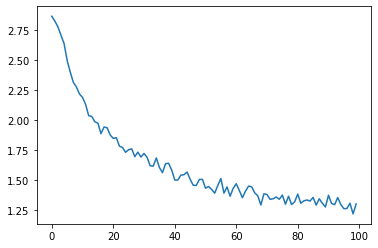

In [20]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

# 结果评价

E:\Anaconda3\envs\sentimentAnalysis\lib\site-packages\ipykernel_launcher.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
E:\Anaconda3\envs\sentimentAnalysis\lib\site-packages\ipykernel_launcher.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator


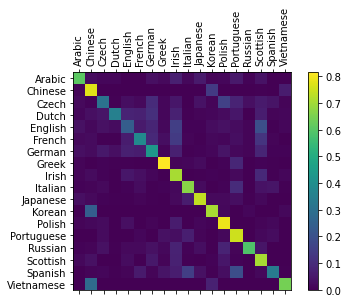

In [22]:
confusion = torch.zeros(n_categories,n_categories)
n_confusion = 10000

def evaluate(line_tensor):
    
    hidden = rnn.initHidden()
    
    for i in range(line_tensor.size()[0]):
        output,hidden = rnn(line_tensor[i],hidden)
        
    return output

for i in range(n_confusion):
    category,line,category_tensor,line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess,guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1
    
for i in range(n_categories):
    confusion[i] = confusion[i]/confusion[i].sum()
    
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

# 运行用户输入

In [31]:
def predict(input_line,n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        
        output = evaluate(lineToTensor(input_line))
        
        topv,topi = output.topk(n_predictions,1,True)
        predictions = []
        
        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s ' % (value,all_categories[category_index]))
            predictions.append([value,all_categories[category_index]])

In [40]:
predict('jack')
predict('bin')


> jack
(-1.18) Czech 
(-1.62) German 
(-2.11) Polish 

> bin
(-1.30) Russian 
(-1.98) French 
(-2.12) Irish 
